<a href="https://colab.research.google.com/github/poligenius/PlantsSegmentation/blob/main/Bipbip_Maize_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DESCRIPTION
In this notebook we tried different pretrained models on the configuration of our best model, all the tries and results are annotated in this notebook.

In [ ]:
# Working on Maize dataset of BipBip

# Dataset scripts

## Get dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd "/content/drive/MyDrive/Segmentation/"

In [ ]:
!mkdir StarterKit
!mkdir dataset

In [ ]:
!wget "https://competitions.codalab.org/my/datasets/download/29a85805-2d8d-4701-a9ab-295180c89eb3"
%cd /content/drive/MyDrive/Segmentation/dataset
!unzip /content/drive/MyDrive/Segmentation/29a85805-2d8d-4701-a9ab-295180c89eb3
!rm /content/drive/MyDrive/Segmentation/29a85805-2d8d-4701-a9ab-295180c89eb3

In [ ]:
%cd /content/drive/MyDrive/Segmentation/
!wget https://competitions.codalab.org/my/datasets/download/39b5fb53-4338-4f0a-8776-7010abbe2e55
%cd /content/drive/MyDrive/Segmentation/StarterKit
!unzip /content/drive/MyDrive/Segmentation/39b5fb53-4338-4f0a-8776-7010abbe2e55
!rm /content/drive/MyDrive/Segmentation/39b5fb53-4338-4f0a-8776-7010abbe2e55

## Prepare dataset

In [ ]:
# We get the list of file in dataset and then we extract the 10% from it to
# create the validation set

In [ ]:
# We fix the seed to have always the same split and the mask corresponding to
# their corresponding images
SEED = 1234

%cd /content/drive/MyDrive/Segmentation/dataset/Development_Dataset/Training/Weedelec/Mais/Images/
import os
import random

random.seed(SEED)
training_list = os.listdir()
k = int(len(training_list)*0.1)
validation_list = random.choices(training_list, k=k)
for val in validation_list:
  training_list.remove(val)
validation_list

In [ ]:
%cd /content/drive/MyDrive/Segmentation/dataset/Development_Dataset/Training/Weedelec/Mais/Splits/
with open("train.txt", "w") as train:
  for t in training_list:
    name, _ = t.split(".")
    train.write(name+"\n")

In [ ]:
%cd /content/drive/MyDrive/Segmentation/dataset/Development_Dataset/Training/Weedelec/Mais/Splits/
with open("val.txt", "w") as val:
  for v in validation_list:
    name, _ = v.split(".")
    val.write(name+"\n")

# Segmentation

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
import numpy as np
from math import ceil

# Set the seed for random operations.
# This let our experiments to be reproducible.
SEED = 1234
tf.random.set_seed(SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Example: Image Segmentation
## Build segmentation

In [ ]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect',
                                      rescale=1./255)
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [ ]:
import os
import numpy as np
from PIL import Image


def read_rgb_mask(img_path):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

In [ ]:
from PIL import Image
all = False # if True use all datasets otherwise only one

if all:
  class CustomDataset(tf.keras.utils.Sequence):

    """
      CustomDataset inheriting from tf.keras.utils.Sequence.

      3 main methods:
        - __init__: save dataset params like directory, filenames..
        - __len__: return the total number of samples in the dataset
        - __getitem__: return a sample from the dataset

      Note:
        - the custom dataset return a single sample from the dataset. Then, we use
          a tf.data.Dataset object to group samples into batches.
        - in this case we have a different structure of the dataset in memory.
          We have all the images in the same folder and the training and validation splits
          are defined in text files.

    """

    def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None,
                preprocessing_function=None, out_shape=[256, 256]):
      subset_filenames = []
      subset_filenames_masks = []
      for dataset in dataset_dir:
        if which_subset == 'training':
          subset_file = os.path.join(dataset, 'Splits', 'train.txt')
        elif which_subset == 'validation':
          subset_file = os.path.join(dataset, 'Splits', 'val.txt')

        with open(subset_file, 'r') as f:
          lines = f.readlines()

        for line in lines:
          subset_filenames.append(dataset+"/Images/"+line.strip())
          subset_filenames_masks.append(dataset+"/Masks/"+line.strip())

      self.which_subset = which_subset
      self.dataset_dir = dataset_dir
      self.subset_filenames = subset_filenames
      self.subset_filenames_masks = subset_filenames_masks
      self.img_generator = img_generator
      self.mask_generator = mask_generator
      self.preprocessing_function = preprocessing_function
      self.out_shape = out_shape

    def __len__(self):
      return len(self.subset_filenames)

    def __getitem__(self, index):
      # Read Image
      curr_filename = self.subset_filenames[index]
      curr_mask = self.subset_filenames_masks[index]
      if "Roseau" in curr_filename:
        ext = ".png"
      else:
        ext = ".jpg"
      img = Image.open(curr_filename + ext)
      mask = read_rgb_mask(curr_mask + '.png')
      mask = Image.fromarray(mask, "P")
      # mask = Image.open(curr_mask + '.png')

      # Resize image and mask
      img = img.resize(self.out_shape)
      mask = mask.resize(self.out_shape, resample=Image.NEAREST)

      img_arr = np.array(img)
      mask_arr = np.array(mask)

      # in this dataset 255 mask label is assigned to an additional class, which corresponds
      # to the contours of the objects. We remove it for simplicity.
      mask_arr[mask_arr == 255] = 0

      mask_arr = np.expand_dims(mask_arr, -1)

      if self.which_subset == 'training':
        if self.img_generator is not None and self.mask_generator is not None:
          # Perform data augmentation
          # We can get a random transformation from the ImageDataGenerator using get_random_transform
          # and we can apply it to the image using apply_transform
          img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
          mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
          img_arr = self.img_generator.apply_transform(img_arr, img_t)
          # ImageDataGenerator use bilinear interpolation for augmenting the images.
          # Thus, when applied to the masks it will output 'interpolated classes', which
          # is an unwanted behaviour. As a trick, we can transform each class mask
          # separately and then we can cast to integer values (as in the binary segmentation notebook).
          # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
          out_mask = np.zeros_like(mask_arr)
          for c in np.unique(mask_arr):
            if c > 0:
              curr_class_arr = np.float32(mask_arr == c)
              curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
              # from [0, 1] to {0, 1}
              curr_class_arr = np.uint8(curr_class_arr)
              # recover original class
              curr_class_arr = curr_class_arr * c
              out_mask += curr_class_arr
      else:
        out_mask = mask_arr

      if self.preprocessing_function is not None:
          img_arr = self.preprocessing_function(img_arr)

      return img_arr, np.float32(out_mask)

else: #Using only one dataset
  class CustomDataset(tf.keras.utils.Sequence):

    """
      CustomDataset inheriting from tf.keras.utils.Sequence.

      3 main methods:
        - __init__: save dataset params like directory, filenames..
        - __len__: return the total number of samples in the dataset
        - __getitem__: return a sample from the dataset

      Note:
        - the custom dataset return a single sample from the dataset. Then, we use
          a tf.data.Dataset object to group samples into batches.
        - in this case we have a different structure of the dataset in memory.
          We have all the images in the same folder and the training and validation splits
          are defined in text files.

    """

    def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None,
                preprocessing_function=None, out_shape=[256, 256]):
      if which_subset == 'training':
        subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
      elif which_subset == 'validation':
        subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')

      with open(subset_file, 'r') as f:
        lines = f.readlines()

      subset_filenames = []
      for line in lines:
        subset_filenames.append(line.strip())

      self.which_subset = which_subset
      self.dataset_dir = dataset_dir
      self.subset_filenames = subset_filenames
      self.img_generator = img_generator
      self.mask_generator = mask_generator
      self.preprocessing_function = preprocessing_function
      self.out_shape = out_shape

    def __len__(self):
      return len(self.subset_filenames)

    def __getitem__(self, index):
      # Read Image
      curr_filename = self.subset_filenames[index]
      img = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename + '.jpg'))
      mask = read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))
      mask = Image.fromarray(mask, "P")

      # Resize image and mask
      img = img.resize(self.out_shape)
      mask = mask.resize(self.out_shape, resample=Image.NEAREST)

      img_arr = np.array(img)
      mask_arr = np.array(mask)

      # in this dataset 255 mask label is assigned to an additional class, which corresponds
      # to the contours of the objects. We remove it for simplicity.
      mask_arr[mask_arr == 255] = 0

      mask_arr = np.expand_dims(mask_arr, -1)

      if self.which_subset == 'training':
        if self.img_generator is not None and self.mask_generator is not None:
          # Perform data augmentation
          # We can get a random transformation from the ImageDataGenerator using get_random_transform
          # and we can apply it to the image using apply_transform
          img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
          mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
          img_arr = self.img_generator.apply_transform(img_arr, img_t)
          # ImageDataGenerator use bilinear interpolation for augmenting the images.
          # Thus, when applied to the masks it will output 'interpolated classes', which
          # is an unwanted behaviour. As a trick, we can transform each class mask
          # separately and then we can cast to integer values (as in the binary segmentation notebook).
          # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
          out_mask = np.zeros_like(mask_arr)
          for c in np.unique(mask_arr):
            if c > 0:
              curr_class_arr = np.float32(mask_arr == c)
              curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
              # from [0, 1] to {0, 1}
              curr_class_arr = np.uint8(curr_class_arr)
              # recover original class
              curr_class_arr = curr_class_arr * c
              out_mask += curr_class_arr
      else:
        out_mask = mask_arr

      if self.preprocessing_function is not None:
          img_arr = self.preprocessing_function(img_arr)

      return img_arr, np.float32(out_mask)

In [ ]:
#preprocess of vgg
#from tensorflow.keras.applications.vgg16 import preprocess_input

#preprocess of resnet
#from tensorflow.keras.applications.resnet import preprocess_input

#preprocess of Xception
#from tensorflow.keras.applications.Xception import preprocess_input

#preprocess of resnetv2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

img_h = 1536
img_w = 2048

if all:
  dataset_dir = ["/content/drive/MyDrive/Segmentation/dataset/Development_Dataset/Training/Bipbip/Mais",
                 "/content/drive/MyDrive/Segmentation/dataset/Development_Dataset/Training/Roseau/Mais",
                 "/content/drive/MyDrive/Segmentation/dataset/Development_Dataset/Training/Weedelec/Mais"
                ]
else:
  dataset_dir = "/content/drive/MyDrive/Segmentation/dataset/Development_Dataset/Training/Bipbip/Mais"


dataset = CustomDataset(dataset_dir, 'training',
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=preprocess_input, out_shape=[img_w, img_h])
dataset_valid = CustomDataset(dataset_dir, 'validation',
                              preprocessing_function=preprocess_input, out_shape=[img_w, img_h])


In [ ]:
batch_size = 1
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(batch_size)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(batch_size)

valid_dataset = valid_dataset.repeat()

In [ ]:
test_augmentation = False
# Assign a color to each class
from matplotlib import cm
evenly_spaced_interval = np.linspace(0, 1, 2)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]
if test_augmentation:
  # Let's test data generator
  # -------------------------
  import time
  import matplotlib.pyplot as plt

  %matplotlib inline

  iterator = iter(valid_dataset)

In [ ]:
if test_augmentation:
  fig, ax = plt.subplots(1, 2)

  augmented_img, target = next(iterator)
  augmented_img = augmented_img[0]   # First element
  augmented_img = augmented_img  # denormalize

  target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

  #print(np.unique(target))

  target_img = np.zeros([target.shape[0], target.shape[1], 3])

  target_img[np.where(target == 0)] = [0, 0, 0]
  for i in range(1, 3):
    target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

  ax[0].imshow(np.uint8(augmented_img))
  ax[1].imshow(np.uint8(target_img))

  plt.show()

In [ ]:
fine_tune = True
#We tried different pretrained models to choose the best one
# .VGG16-->best one so far, up to 81% accuracy
# .Xception--> around 70% withbthe best configuration
# .NasNetLarge--> bad results, too slow
# .VGG19--> 76% with Adam lr=1e-4, 72% with Adam lr=1e-3, 66% with Adam lr=1e-5
# .ResNet50--> 77% with all layers, 78% with 140 layers frozen, 76% with 150 layers, 79,65% with 130 layers with preprocess of vgg
#              resnet preprocess is equivalente to the preprocess of vgg, we tried both.
# .ResNet50V2-->   similar results with respect of ResNet50
#pretrainedModel = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
#pretrainedModel = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
#pretrainedModel = tf.keras.applications.NASNetLarge(weights="imagenet", include_top=False, input_shape=(img_h, img_w, 3))
#pretrainedModel = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
#pretrainedModel = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
pretrainedModel = tf.keras.applications.ResNet50V2(include_top=False, weights="imagenet", input_tensor=None, input_shape=(img_h, img_w, 3))

pretrainedModel.summary()

#we tried to unfreeze different numbers of layers we use the rule of thumb of unfreezing 1/3 of the net it has always shown the best results
#.12 was the best for VGG16
#.130 was the best for resnet
#
if fine_tune:
  for layer in pretrainedModel.layers[:127]:
    layer.trainable = False
  for layer in pretrainedModel.layers[127:]:
    layer.trainable = True
else:
  for layer in pretrainedModel.layers:
    layer.trainable = False

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1536, 2048,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 1542, 2054, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 768, 1024, 64 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 770, 1026, 64 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

## Convolutional Neural Network (CNN)
### Encoder-Decoder

In [ ]:
def create_model(depth, start_f, num_classes):

    model = tf.keras.Sequential()

    # Encoder
    # -------
    model.add(pretrainedModel)

    #original value of start_f was 256
    start_f = 256

    # Decoder
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))

    return model

In [ ]:
num_classes = 3
model = create_model(depth=5,
                     start_f=8,
                     num_classes=num_classes)

# Visualize created model as a table
# model.summary()

# Visualize initialized weights
# model.weights

## Prepare the model for training

In [ ]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
# loss = tf.keras.losses.SparseCategoricalCrossentropy()
#from focal_loss import SparseCategoricalFocalLoss
from keras import backend as K
from tensorflow.keras.backend import flatten

def weighted_categorical_crossentropy(weights):
    weights = K.variable(weights)

    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss

    return loss

#Here we define the dice_coef a useful metric to evaluate the performance of our model
#we implemented it to explore different losses and see which one works best for our task
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

#We tried also weighted_categorical_crossentropy and SparseCategoricalFocalLoss too see which one works best for our task
#the best one revealed to be SparseCategoricalCrossentropy
# loss = weighted_categorical_crossentropy(np.array([0.6,1,1]))
#loss = SparseCategoricalFocalLoss(gamma=2)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

# learning rate we tried different values but the best one looks to be 1e-4
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,num_classes): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection

      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Training with callbacks

In [ ]:
import os
from datetime import datetime
from tensorflow.keras.callbacks import ReduceLROnPlateau

cwd = os.getcwd()

exps_dir = os.path.join('/content/drive/MyDrive/Segmentation/', 'multiclass_segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'),
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)

# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    callbacks.append(es_callback)

#trying to reduce lr to increase the performances by the way it didn't improved the performance
lrop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6)
#callbacks.append(lrop_callback)

In [ ]:
model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=ceil(len(dataset)/batch_size),
          validation_data=valid_dataset,
          validation_steps=ceil(len(dataset_valid)/batch_size),
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Epoch 1/100
81/81 [==============================] - 229s 3s/step - loss: 0.2057 - accuracy: 0.9224 - meanIoU: 0.4460 - val_loss: 0.1126 - val_accuracy: 0.9619 - val_meanIoU: 0.5763
Epoch 2/100
81/81 [==============================] - 167s 2s/step - loss: 0.0765 - accuracy: 0.9700 - meanIoU: 0.6887 - val_loss: 0.0880 - val_accuracy: 0.9687 - val_meanIoU: 0.6447
Epoch 3/100
81/81 [==============================] - 166s 2s/step - loss: 0.0662 - accuracy: 0.9731 - meanIoU: 0.7111 - val_loss: 0.0792 - val_accuracy: 0.9711 - val_meanIoU: 0.6864
Epoch 4/100
81/81 [==============================] - 166s 2s/step - loss: 0.0676 - accuracy: 0.9720 - meanIoU: 0.7041 - val_loss: 0.0978 - val_accuracy: 0.9654 - val_meanIoU: 0.6342
Epoch 5/100
81/81 [==============================] - 165s 2s/step - loss: 0.0582 - accuracy: 0.9758 - meanIoU: 0.7441 - val_loss: 0.0762 - val_accuracy: 0.9728 - val_meanIoU: 0.6909
Epoch 6/100
81/81 [==============================] - 164s 2s/step - loss: 0.0519 - accurac

## Test model

## Compute prediction

In [ ]:
#model.load_weights('/content/drive/MyDrive/Segmentation/multiclass_segmentation_experiments/CNN_Dec08_21-45-56/ckpts/cp_14.ckpt')

In [ ]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(valid_dataset)

(1, 1536, 2048, 3)

<tf.Tensor: shape=(2048,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>

<tf.Tensor: shape=(2048,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>

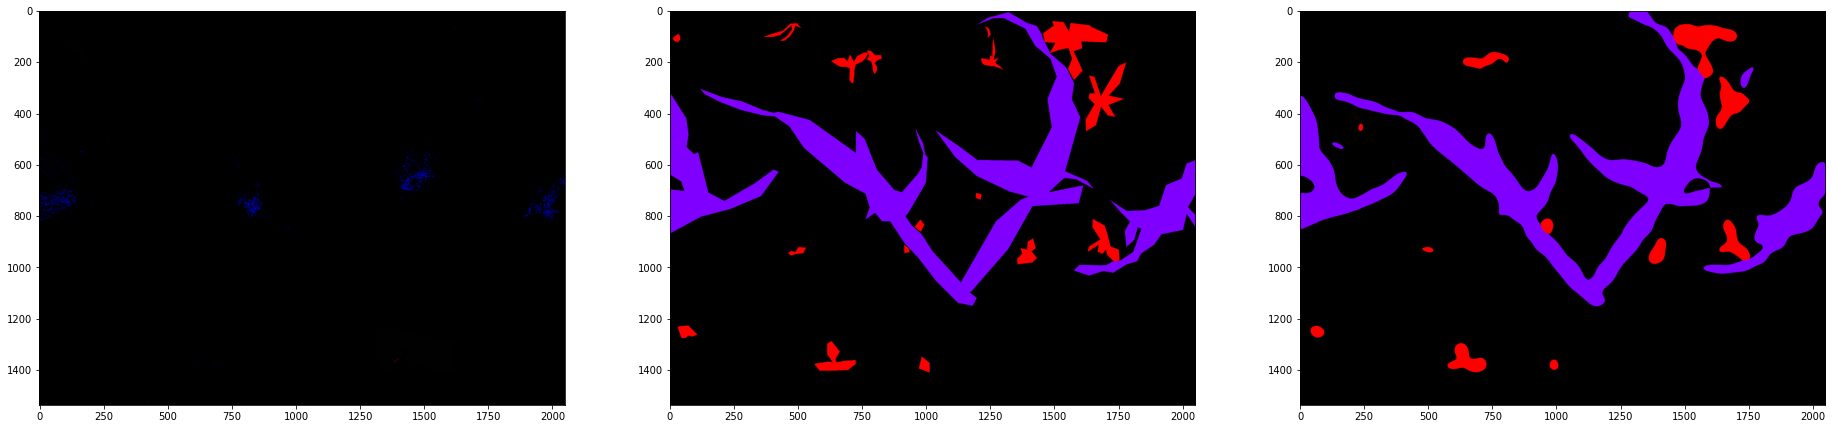

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(32, 32))
fig.show()
image, target = next(iterator)

image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, num_classes):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, num_classes):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255
  predicted_class[i]

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)

# Create submission

In [ ]:
# Function to encode the predictions in RLE
def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
import json
import pandas as pd

# Create validation and test ImageDataGenerator objects
test_img_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

bs = 1

#to create the submission files we parse all the images of the test sets, and compute the prediction only for Maize datasets since
#we trained the model with Maize images
test_dirs = ["/content/drive/MyDrive/Segmentation/dataset/Development_Dataset/Test_Dev/Bipbip/Mais",
             "/content/drive/MyDrive/Segmentation/dataset/Development_Dataset/Test_Dev/Bipbip/Haricot",
             "/content/drive/MyDrive/Segmentation/dataset/Development_Dataset/Test_Dev/Pead/Mais",
             "/content/drive/MyDrive/Segmentation/dataset/Development_Dataset/Test_Dev/Pead/Haricot",
             "/content/drive/MyDrive/Segmentation/dataset/Development_Dataset/Test_Dev/Roseau/Mais",
             "/content/drive/MyDrive/Segmentation/dataset/Development_Dataset/Test_Dev/Roseau/Haricot",
             "/content/drive/MyDrive/Segmentation/dataset/Development_Dataset/Test_Dev/Weedelec/Mais",
             "/content/drive/MyDrive/Segmentation/dataset/Development_Dataset/Test_Dev/Weedelec/Haricot"]

submission_dict = {}
for test_dir in test_dirs:
  team, crop = test_dir.split("/")[8], test_dir.split("/")[9]
  print(team, crop)

  test_dir = os.path.join(test_dir, 'Images')
  images = [f for f in os.listdir(test_dir)]
  images = pd.DataFrame(images)
  images.rename(columns = {0:'filename'}, inplace = True)
  images["class"] = 'test'

  test_gen = test_img_data_gen.flow_from_dataframe(images,
                                                  test_dir,
                                                  batch_size=bs,
                                                  target_size=(img_h, img_w),
                                                  class_mode=None,
                                                  shuffle=False,
                                                  seed=SEED)
  test_gen.reset()
  if "Mais" in test_dir:
    predictions = model.predict(test_gen, len(test_gen), verbose=1)
  else:
    predictions = []
    for i in range(len(test_gen)):
      predictions.append("")
  results = {}
  images = test_gen.filenames
  counter = 0
  for img in images:
    name, ext = img.split(".")
    images[counter] = name
    counter += 1

  i = 0

  for mask_arr in predictions:
    submission_dict[images[i]] = {}
    image = Image.open(test_dir + "/" + images[i] + "." + ext)
    shape = (image.size[1], image.size[0])
    submission_dict[images[i]]['shape'] = shape
    submission_dict[images[i]]['team'] = team
    submission_dict[images[i]]['crop'] = crop
    submission_dict[images[i]]['segmentation'] = {}

    if crop == "Mais":
      #mask_arr = tf.argmax(mask_arr, -1)[0, ...] # (256, 256)
      mask_arr = tf.argmax(mask_arr, axis=-1)
      mask_arr = np.resize(mask_arr, (img_h, img_w))
      mask_arr = np.array(mask_arr)
      print(mask_arr)
      # RLE encoding
      # crop
      rle_encoded_crop = rle_encode(mask_arr == 1)
      # weed
      rle_encoded_weed = rle_encode(mask_arr == 2)

      submission_dict[images[i]]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[images[i]]['segmentation']['weed'] = rle_encoded_weed
    else:
      submission_dict[images[i]]['segmentation']['crop'] = ""
      submission_dict[images[i]]['segmentation']['weed'] = ""
    i += 1

    # Please notice that in this example we have a single prediction.
    # For the competition you have to provide segmentation for each of
    # the test images.

# Finally, save the results into the submission.json file
with open('./submission.json', 'w') as f:
    json.dump(submission_dict, f)

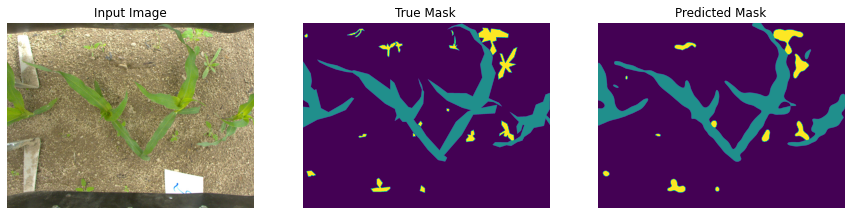

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = np.argmax(pred_mask, axis=-1)
  #pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(image, mask):
    pred_mask = model.predict(image)
    display([image[0], mask[0], create_mask(pred_mask)])

iterator = iter(valid_dataset)
image, target = next(iterator)
show_predictions(image, target)

In [ ]:
# Display test images and predictions

In [ ]:
test_dataset = tf.data.Dataset.from_generator(lambda: test_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

test_dataset = test_dataset.batch(1)

test_dataset = test_dataset.repeat()

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(image):
    pred_mask = model.predict(image)
    display([image[0], create_mask(pred_mask)])

iterator = iter(test_gen)

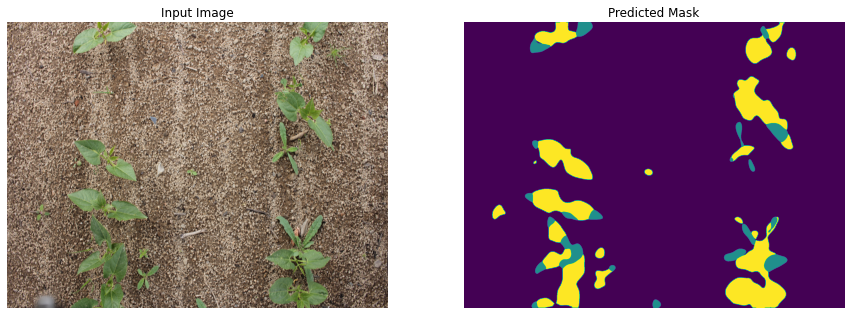

In [ ]:
image = next(iterator)
show_predictions(image)